In [1]:
import torch
import pandas as pd
import tensorflow as tf
import torchvision
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCHS = 1
BATCH_SIZE = 32
N_EVAL = 5


#RESNET
#too many of one type
#

C:\Users\Chris\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_labels = pd.read_csv(r'C:\Users\Chris\AppData\Local\Programs\Python\Python39\Scripts\ACMAI\train.csv')
#print(df_labels)
#print(df_labels.iloc[1][1])

print("0:", df_labels['label'].value_counts()[0])
print("1:", df_labels['label'].value_counts()[1])
print("2:", df_labels['label'].value_counts()[2])
print("3:", df_labels['label'].value_counts()[3])
print("4:", df_labels['label'].value_counts()[4])


0: 1087
1: 2189
2: 2386
3: 13158
4: 2577


In [65]:
print(df_labels)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [64]:
for i in df_labels.iterrows():
    print(i[1])

image_id    1000015157.jpg
label                    0
Name: 0, dtype: object
image_id    1000201771.jpg
label                    3
Name: 1, dtype: object
image_id    100042118.jpg
label                   1
Name: 2, dtype: object
image_id    1000723321.jpg
label                    1
Name: 3, dtype: object
image_id    1000812911.jpg
label                    3
Name: 4, dtype: object
image_id    1000837476.jpg
label                    3
Name: 5, dtype: object
image_id    1000910826.jpg
label                    2
Name: 6, dtype: object
image_id    1001320321.jpg
label                    0
Name: 7, dtype: object
image_id    1001723730.jpg
label                    4
Name: 8, dtype: object
image_id    1001742395.jpg
label                    3
Name: 9, dtype: object
image_id    1001749118.jpg
label                    3
Name: 10, dtype: object
image_id    100204014.jpg
label                   3
Name: 11, dtype: object
image_id    1002088496.jpg
label                    1
Name: 12, dtype: object


In [3]:
#send to gpu

if torch.cuda.is_available(): # Check if GPU is available
  device = torch.device('cuda')
  print("GPU")
else:
  device = torch.device('cpu')
  print("CPU")

# Move the model to the GPU
# model = model.to(device)
# model

GPU


In [4]:
# Make a Dataset of file names including all the PNG images files in
# the relative image directory.
# filename_dataset = tf.data.Dataset.list_files(r"C:\Users\Chris\AppData\Local\Programs\Python\Python39\Scripts\ACMAI\train_images")

# # Make a Dataset of image tensors by reading and decoding the files.
# image_dataset = filename_dataset.map(lambda x: tf.decode_png(tf.read_file(x)))

# # NOTE: You can add additional transformations, like 
# # `image_dataset.batch(BATCH_SIZE)` or `image_dataset.repeat(NUM_EPOCHS)`
# # in here.

# iterator = image_dataset.make_one_shot_iterator()
# next_image = iterator.get_next()

# # Start a new session to show example output.
# with tf.Session() as sess:

#   try:

#     while True:
#       # Get an image tensor and print its value.
#       image_array = sess.run([next_image])
#       print(image_tensor)

#   except tf.errors.OutOfRangeError:
#     # We have reached the end of `image_dataset`.
#     pass

In [4]:
data_dir = (r'C:\Users\Chris\AppData\Local\Programs\Python\Python39\Scripts\ACMAI\train_images')

#filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']
filenames = [name for name in os.listdir(data_dir)]

batch_size = len(filenames)
batch = torch.zeros(batch_size, 3, 600, 800, dtype=torch.uint8)
for i, filename in enumerate(filenames):
    batch[i] = torchvision.io.read_image(os.path.join(data_dir, filename))

print(batch_size)


#plt.imshow(batch[0].permute(1, 2, 0))
# fig = plt.figure(figsize=(8, 2))
# for i in range(batch.shape[0]) :
#     ax = fig.add_subplot(1, 3, i+1)
#     ax.imshow(batch[i].permute(1, 2, 0))


21397


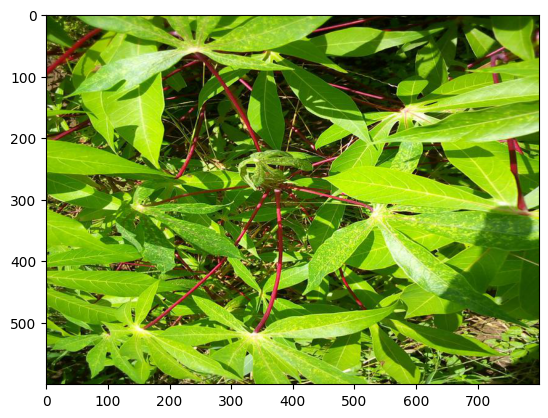

In [5]:
plt.imshow(batch[21396].permute(1, 2, 0))

In [6]:
class StartingDataset(torch.utils.data.Dataset):
    """
    Dataset that contains 100000 3x224x224 black images (all zeros).
    Need 800x600
    """

    #labels = df_labels
    #items = batch
    
    def __init__(self, labels, items):
        self.labels = labels
        self.items = items
        pass

    def __getitem__(self, index):
        image = self.items[index]
        label = self.labels.iloc[index][1]
        return image, label

    def __len__(self):
        return len(self.items)

In [18]:
class StartingNetwork(torch.nn.Module):
    """
    Basic logistic regression on 224x224x3 images.
    Need 600x800
    """

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(600 * 800 * 3, 5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = x.to(torch.float32)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [49]:
class ConvNet(nn.Module):
  def __init__(self):
    # Call nn.Module's constructor--don't forget this
    super().__init__()

    """
    Define layers
    """
    # Explanation of arguments
    # Remember a Convolution layer will take some input volume HxWxC
    # (H = height, W = width, and C = channels) and map it to some output
    # volume H'xW'xC'.
    #
    # Conv2d expects the following arguments
    #   - C, the number of channels in the input
    #   - C', the number of channels in the output
    #   - The filter size (called a kernel size in the documentation)
    #     Below, we specify 5, so our filters will be of size 5x5.
    #   - The amount of padding (default = 0)
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5, padding=2) #notice how we use padding to prevent dimension reduction
    self.conv2 = nn.Conv2d(10, 15, kernel_size=3, padding=1)

    # Pooling layer takes two arguments
    #   - Filter size (in this case, 2x2)
    #   - Stride
    self.pool = nn.MaxPool2d(10, 2)

    self.fc1 = nn.Linear(800, 400)
    self.fc2 = nn.Linear(400, 100)
    self.fc3 = nn.Linear(100, 25)
    self.fc4 = nn.Linear(25, 5)

  def forward(self, x):
    # Comments below give the shape of x
    # n is batch size

    # (n, 1, 28, 28)
    print("Conv1", x.shape())
    x = self.conv1(x)
    x = F.relu(x)
    # (n, 4, 28, 28)
    x = self.pool(x)
    # (n, 4, 14, 14)
    print("Conv2", x.shape())
    x = self.conv2(x)
    x = F.relu(x)
    # (n, 8, 14, 14)
    x = self.pool(x)
    # (n, 8, 7, 7)
    x = torch.reshape(x, (-1, 800))
    # (n, 8 * 7 * 7)
    x = self.fc1(x)
    x = F.relu(x)
    # (n, 256)
    x = self.fc2(x)
    x = F.relu(x)
    # (n, 128)
    x = self.fc3(x)
    x = F.relu(x)
    # (n, 10)
    x = self.fc4(x)
    return x

In [50]:
def starting_train(train_dataset, val_dataset, model, hyperparameters, n_eval):
    """
    Trains and evaluates a model.

    Args:
        train_dataset:   PyTorch dataset containing training data.
        val_dataset:     PyTorch dataset containing validation data.
        model:           PyTorch model to be trained.
        hyperparameters: Dictionary containing hyperparameters.
        n_eval:          Interval at which we evaluate our model.
    """

    # Get keyword arguments
    batch_size, epochs = hyperparameters["batch_size"], hyperparameters["epochs"]

    # Initialize dataloaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True
    )

    # Initalize optimizer (for gradient descent) and loss function
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    step = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} of {epochs}")

        # Loop over each batch in the dataset
        for batchx in tqdm(train_loader):
            images, labels = batchx

            # Move inputs over to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images) # Same thing as model.forward(images)

            # Backprop
            loss = loss_fn(outputs, labels)
            loss.backward()       # Compute gradients
            optimizer.step()      # Update all the weights with the gradients you just calculated
            optimizer.zero_grad() # Clear gradients before next iteration
            
            outputs = outputs.argmax(axis=1)
            
            # Periodically evaluate our model + log to Tensorboard
            if step % n_eval == 0:
                #model.eval()?????
                
                # TODO:
                # Compute training loss and accuracy.
                #loss = loss_fn(outputs,labels)
                #print(outputs,labels)
                batchAccuracy = compute_accuracy(outputs, labels)
                print(batchAccuracy)
                
                # Log the results to Tensorboard.

                # TODO:
                # Compute validation loss and accuracy.
                # Log the results to Tensorboard.
                # Don't forget to turn off gradient calculations!
                #torch.no_grad()??
                #evaluate(val_loader, model, loss_fn)
                #torch.grad()??
                #model.train()??
                print('Epoch:', epoch, 'Loss:', loss.item())

            step += 1

        print()


def compute_accuracy(outputs, labels):
    """
    Computes the accuracy of a model's predictions.

    Example input:
        outputs: [0.7, 0.9, 0.3, 0.2]
        labels:  [1, 1, 0, 1]

    Example output:
        0.75
    """
#     print(outputs.shape, labels.shape)
    print(outputs,labels)
    n_correct = (torch.round(outputs) == labels).sum().item()
    
    n_total = len(outputs)
    return n_correct / n_total


def evaluate(val_loader, model, loss_fn):
    """
    Computes the loss and accuracy of a model on the validation dataset.

    TODO!
    """
#     correct = 0
#     total = 0
#     with torch.no_grad(): # IMPORTANT: turn off gradient computations
#         for batch in test_loader:
#             images, labels = batch
#             images = images.to(device)
#             labels = labels.to(device)

#             images = torch.reshape(images, (-1, 1, 28, 28))
#             outputs = model(images)
#             predictions = torch.argmax(outputs, dim=1)

#     # labels == predictions does an elementwise comparison
#     # e.g.                labels = [1, 2, 3, 4]
#     #                predictions = [1, 4, 3, 3]
#     #      labels == predictions = [1, 0, 1, 0]  (where 1 is true, 0 is false)
#     # So the number of correct predictions is the sum of (labels == predictions)
#             correct += (labels == predictions).int().sum()
#             total += len(predictions)

#     print('Accuracy:', (correct / total).item())
    
    
    
    pass


In [52]:
#import os

#import constants
#from data.StartingDataset import StartingDataset
#from networks.StartingNetwork import StartingNetwork
#from train_functions.starting_train import starting_train


def main():
    # Get command line arguments
    hyperparameters = {"epochs": EPOCHS, "batch_size": BATCH_SIZE}

    # TODO: Add GPU support. This line of code might be helpful.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    print("Epochs:", EPOCHS)
    print("Batch size:", BATCH_SIZE)

    # Initalize dataset and model. Then train the model!
    train_dataset = StartingDataset(df_labels, batch)
    val_dataset = StartingDataset(df_labels, batch)
    model = StartingNetwork()
    model = model.to(device)
    starting_train(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        model=model,
        hyperparameters=hyperparameters,
        n_eval=N_EVAL,
                    )


if __name__ == "__main__":
    main()


cuda
Epochs: 1
Batch size: 32
Epoch 1 of 1


  0%|                                                                                          | 0/669 [00:00<?, ?it/s]

tensor([2, 1, 1, 1, 2, 1, 1, 2, 1, 4, 2, 4, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 1], device='cuda:0') 

  0%|                                                                                  | 1/669 [00:00<01:17,  8.62it/s]

tensor([3, 3, 1, 3, 3, 2, 3, 4, 4, 3, 3, 3, 2, 3, 4, 3, 3, 3, 4, 3, 1, 1, 2, 4,
        3, 3, 2, 3, 1, 4, 3, 2], device='cuda:0')
0.09375
Epoch: 0 Loss: 1.5297883749008179


  1%|▊                                                                                 | 7/669 [00:00<01:14,  8.88it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 1, 3, 4, 4, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 2,
        3, 3, 0, 3, 4, 3, 2, 3], device='cuda:0')
0.65625
Epoch: 0 Loss: 1.3883686065673828


  2%|█▍                                                                               | 12/669 [00:01<01:20,  8.21it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 1, 3, 3, 3, 1, 3, 4, 3, 3, 2, 1, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 1, 3,
        3, 3, 1, 0, 3, 3, 3, 3], device='cuda:0')
0.625
Epoch: 0 Loss: 1.3571186065673828


  3%|██                                                                               | 17/669 [00:01<01:16,  8.48it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 4, 2, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 4, 3, 3, 1, 3, 3, 3, 4, 4, 1, 3,
        3, 4, 3, 3, 3, 2, 2, 1], device='cuda:0')
0.59375
Epoch: 0 Loss: 1.3825756311416626


  3%|██▋                                                                              | 22/669 [00:02<01:13,  8.79it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 4, 3, 3, 3, 3, 4, 3, 2, 3, 0, 4, 3, 2, 1, 3, 0, 3, 1, 3, 3, 3, 3, 4,
        1, 3, 3, 3, 3, 3, 2, 3], device='cuda:0')
0.625
Epoch: 0 Loss: 1.3883686065673828


  4%|███▎                                                                             | 27/669 [00:03<01:23,  7.72it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([4, 3, 2, 3, 4, 3, 0, 3, 4, 0, 3, 3, 3, 3, 3, 4, 3, 1, 3, 3, 3, 0, 3, 3,
        4, 2, 3, 3, 3, 3, 3, 3], device='cuda:0')
0.65625
Epoch: 0 Loss: 1.3200756311416626


  5%|███▊                                                                             | 32/669 [00:03<01:36,  6.58it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 1, 2, 4, 3, 2, 3, 2, 3, 3, 3, 4, 3, 3, 4, 3, 0, 4, 3, 3, 3, 3, 3, 3,
        0, 3, 1, 3, 3, 3, 3, 3], device='cuda:0')
0.65625
Epoch: 0 Loss: 1.3513256311416626


  6%|████▍                                                                            | 37/669 [00:04<01:23,  7.53it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 1, 0, 4, 0, 3, 3, 1, 4, 3, 3, 2, 4, 3, 3,
        3, 3, 3, 2, 2, 3, 3, 3], device='cuda:0')
0.59375
Epoch: 0 Loss: 1.4450756311416626


  6%|█████                                                                            | 42/669 [00:05<01:14,  8.39it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 1, 2, 3, 3, 3, 4, 4, 2, 4, 4, 3, 2, 3, 0, 4, 3, 1, 0, 3, 3, 3, 1, 3,
        2, 4, 3, 3, 4, 3, 1, 4], device='cuda:0')
0.4375
Epoch: 0 Loss: 1.4450756311416626


  7%|█████▋                                                                           | 47/669 [00:05<01:24,  7.40it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([2, 2, 2, 3, 0, 3, 2, 3, 3, 2, 3, 4, 4, 3, 3, 3, 0, 4, 3, 2, 3, 0, 2, 3,
        3, 3, 0, 1, 3, 1, 1, 3], device='cuda:0')
0.46875
Epoch: 0 Loss: 1.5700756311416626


  8%|██████▏                                                                          | 51/669 [00:07<02:15,  4.57it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 4, 0, 3, 1, 1,
        3, 2, 1, 1, 1, 3, 3, 4], device='cuda:0')
0.625
Epoch: 0 Loss: 1.4450756311416626


  9%|██████▉                                                                          | 57/669 [00:10<05:04,  2.01it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 3, 4, 2, 3, 4, 3, 1, 3, 3, 3, 4, 3, 3, 1, 4, 4, 3, 4, 3, 3, 2, 3, 4,
        3, 2, 4, 3, 1, 3, 2, 0], device='cuda:0')
0.5
Epoch: 0 Loss: 1.3825756311416626


  9%|███████▍                                                                         | 61/669 [00:10<02:09,  4.69it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([1, 3, 3, 0, 3, 3, 0, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 2, 4, 4, 3, 3, 4, 3,
        3, 3, 3, 3, 3, 3, 3, 1], device='cuda:0')
0.6875
Epoch: 0 Loss: 1.3513256311416626


 10%|███████▉                                                                         | 66/669 [00:12<04:10,  2.41it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 0, 4, 4, 1, 3, 3, 4, 3, 3, 4, 4, 3,
        3, 3, 3, 3, 1, 3, 0, 0], device='cuda:0')
0.59375
Epoch: 0 Loss: 1.3825756311416626


 11%|████████▋                                                                        | 72/669 [00:14<03:24,  2.92it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 3, 4, 4, 2, 3, 1, 3, 2, 3, 1, 1, 2, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 1, 2, 1, 4, 2], device='cuda:0')
0.53125
Epoch: 0 Loss: 1.4450756311416626


 12%|█████████▎                                                                       | 77/669 [00:15<01:39,  5.96it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([1, 3, 3, 3, 3, 1, 4, 3, 2, 3, 4, 3, 1, 1, 1, 3, 3, 2, 3, 3, 1, 4, 3, 3,
        0, 4, 3, 3, 2, 3, 4, 3], device='cuda:0')
0.53125
Epoch: 0 Loss: 1.4450756311416626


 12%|█████████▉                                                                       | 82/669 [00:15<01:32,  6.32it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([1, 3, 3, 3, 2, 4, 3, 3, 3, 3, 4, 1, 0, 3, 0, 3, 3, 3, 1, 3, 2, 3, 4, 3,
        3, 1, 3, 3, 3, 4, 2, 4], device='cuda:0')
0.5625
Epoch: 0 Loss: 1.4138256311416626


 13%|██████████▍                                                                      | 86/669 [00:16<01:53,  5.14it/s]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0') tensor([3, 1, 2, 3, 3, 4, 1, 4, 4, 1, 1, 2, 3, 3, 3, 3, 3, 2, 1, 4, 3, 3, 3, 4,
        3, 3, 3, 2, 3, 3, 3, 3], device='cuda:0')
0.5625
Epoch: 0 Loss: 1.4138256311416626


KeyboardInterrupt: 